In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, datasets

In [2]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [4]:
test_transfrom = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [5]:
data_dir = 'datasets/cifar10/train'
batch_size = 8
num_workers = 2 # subprocesses to use for data loading in dataloader

In [6]:
# load cifar dataset
train_dataset = datasets.CIFAR10(
    root = data_dir,
    train = True,
    download = True,
    transform = train_transform
    )

Files already downloaded and verified


In [7]:
test_dataset = datasets.CIFAR10(
    root = data_dir,
    train = False,
    download = True,
    transform = test_transfrom
    )

Files already downloaded and verified


In [8]:
train_set = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)

In [9]:
test_set = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = num_workers
)

In [10]:
dataloaders = {
    'train':train_set,
    'test':test_set
}

In [11]:
dataset_sizes = { 'train': len(train_set), 'test': len(test_set) }

In [12]:
dataset_sizes #number of batches in training and test data

{'test': 1250, 'train': 6250}

In [13]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [14]:
# for pretrained model
import torchvision.models as models

In [15]:
model = models.resnet18(pretrained=True)

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
for param in model.parameters():
  param.requires_grad = False

In [18]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [19]:
model.fc = nn.Linear(num_ftrs, 10)

In [20]:
device = torch.device('cuda')

if torch.cuda.is_available():
  device = torch.device('cuda')

print(device)

cuda


In [21]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# train and test phase
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer = optimizer_ft, step_size = 7, gamma=0.1)

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        step = 0
        
        for phase in ['train', 'test']:
            
            if phase == 'train':
                scheduler.step()
                model.train(True)  
                # Set model to training mode
                
            else:
                model.train(False)  
                # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                step += 1
                if step % 500 == 0:
                    print('Epoch: {} Loss: {:.4f},  Step: {}'.format(epoch, loss.item(), step))
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double()/ (dataset_sizes[phase]*batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f} '.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    print('Training complete')
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [24]:
model = train_model(model, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 0 Loss: 1.4112,  Step: 500
Epoch: 0 Loss: 1.6262,  Step: 1000
Epoch: 0 Loss: 0.7972,  Step: 1500
Epoch: 0 Loss: 1.2182,  Step: 2000
Epoch: 0 Loss: 1.4370,  Step: 2500
Epoch: 0 Loss: 1.4628,  Step: 3000
Epoch: 0 Loss: 1.8627,  Step: 3500
Epoch: 0 Loss: 1.4868,  Step: 4000
Epoch: 0 Loss: 1.6385,  Step: 4500
Epoch: 0 Loss: 1.4008,  Step: 5000
Epoch: 0 Loss: 1.6239,  Step: 5500
Epoch: 0 Loss: 1.2365,  Step: 6000
train Loss: 11.7612 Acc: 0.4875 
Epoch: 0 Loss: 1.0232,  Step: 6500
Epoch: 0 Loss: 0.6786,  Step: 7000
Epoch: 0 Loss: 0.2433,  Step: 7500
test Loss: 7.1780 Acc: 0.6909 

Training complete
Best test Acc: 0.690900


In [25]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    plt.title(title)
    plt.pause(5)  

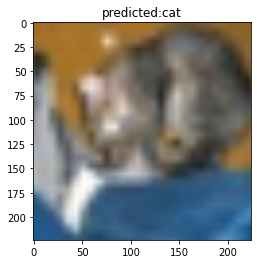

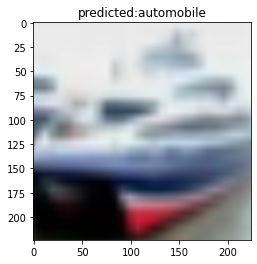

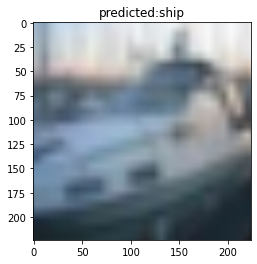

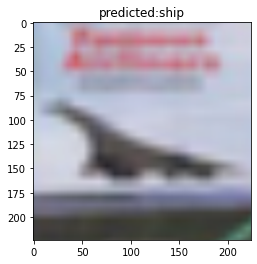

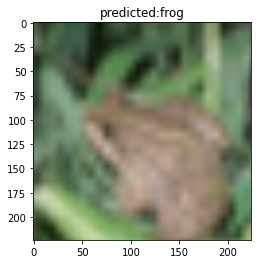

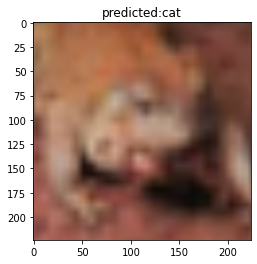

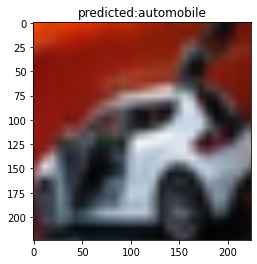

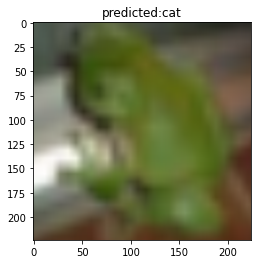

In [26]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    inputs, labels = inputs.to(device), labels.to(device)
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])